C:\Users\YJKIM\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


4.219296217890031
(42.67363951763958+0j)
4


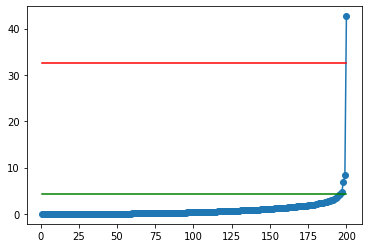

In [7]:
#correlation matrix filtering
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

#data loading
#df = pd.read_csv("correlation_20191001.csv")
df = pd.read_csv("correlation_20191001_ver2.csv")
#correlation dataset: weighted

n = df['1'].size    #find the number of nodes
A = np.zeros((n,n))    #Adjacency matrix
T = 180

for i in range(n):    #build the adjacenty matrix
    for j in range(n):
        A[i,j] = df.values[i,j]
        
eigvals, eigvecs = la.eig(A)    #Find eigenvalues and eigenvectors of A
lambda_plus = (1 + np.sqrt(n/T))**2
lambda_max = max(eigvals)

#Orthonormalize: eigenvectors can be orthonormalized since A is symmetric
eigvecs = eigvecs.T
Y = eigvecs[0:1,:].copy()
for i in range(1, eigvecs.shape[0]):
    proj = np.diag((eigvecs[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
    Y = np.vstack((Y, eigvecs[i,:] - proj.sum(0)))
Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
eigvecs = Y.T

eigvalindex = np.zeros(n)
lambda_decomp = np.ones(n)
for i in range(n):
    eigvalindex[i] = i + 1
plt.plot(eigvalindex,np.sort(eigvals),'o-')
plt.plot(eigvalindex,lambda_plus * lambda_decomp,'g')
plt.plot(eigvalindex,(lambda_max - 10) * lambda_decomp,'r')
plt.show

eigvals = eigvals.astype(np.float64)

C_group = np.zeros((n,n))    #Find the 'group' mode: lambda_plus < lambda < lambda_max
count = 0
for i in range(n):
    if eigvals[i] > lambda_plus and eigvals[i] < lambda_max:
        C_group += eigvals[i] * eigvecs[:,i].reshape((n,1)) * eigvecs[:,i]
        count += 1

print(lambda_plus)
print(lambda_max)
print(count)
# heatmap by plt.pcolor()
#plt.pcolor(df)
#plt.title('Correlation Heatmap', fontsize=20)
#plt.xlabel('KOSPI200', fontsize=14)
#plt.ylabel('KOSPI200', fontsize=14)
#plt.colorbar()

#plt.show()



In [4]:
#modified Louvain Algorithm, phase 1
total_weight = 0
for i in range(n):
    total_weight += sum(A[:,i])
    
A = C_group
degree = np.zeros(n)    #Degree vector
numedge = n * n

for i in range(n):    #build the degree matrix
    degree[i] = sum(A[:,i])    #degree of node i+1

community = np.zeros((n,n))
#첫 단계에서 모든 node를 각각의 community로 설정한다.
for i in range(n):
    community[i,0] = i + 1
community = community.astype(np.int64)

delQ = -np.ones(n)
epsilon = 1e-3
numiteration = 0
delQ_max_temp = 0

while abs(delQ.max()-delQ_max_temp) >= epsilon:  #dQ의 max 값이 변화가 없을 때까지
    delQ_max_temp = delQ.max()
    delQ = np.zeros(n)
    numiteration += 1
    for i in range(n):   #node (i+1)의 initial community 찾기
        communityflag = 0
        community_initial = n
        community_temp = n
        for j in range(n):
            for k in range(n):
                if community[j,k] == (i+1):
                    community_initial = j
                    communityflag = 1
                    break
                elif community[j,k] == 0:
                    break
            if communityflag == 1: break

        k_i_in_out = 0
        sigma_tot_out = 0
        dQ_temp_out = 0
        dQ_temp = 0
        for k in range(n):  #dQ(D->i) 구하기 
            if community[community_initial,k] != (i+1):
                if community[community_initial,k] != 0: 
                    sigma_tot_out += degree[community[community_initial,k]-1]
                    #sigma_tot_out: i의 community에 있는 모든 node의 degree의 합
                    if A[i,community[community_initial,k]-1] != 0:
                        k_i_in_out += A[i,community[community_initial,k]-1]
                        #ki,in_out: community i에 있는 node와 i 사이의 link wieghts 합
                elif community[community_initial,k] == 0: break
        dQ_temp_out = k_i_in_out/total_weight #- degree[i] * sigma_tot_out/(2 * numedge**2)
        
        for j in range(n):    #dQ(i->C 구하기), dQ>0이면서 가장 큰 값을 가지는 community j로 i를 옮긴다.
            if j != community_initial and community[j,0] != 0:
                k_i_in = 0
                sigma_tot = 0
                dQ_temp_in = 0
                for k in range(n):
                    if community[j,k] != 0: 
                        sigma_tot += degree[community[j,k]-1]
                       #sigma_tot: j의 community에 있는 모든 node의 degree의 합
                        if A[i,community[j,k]-1] != 0:
                            k_i_in += A[i,community[j,k]-1]  
                            #ki,in: community j에 있는 node와 i 사이의 link wieghts 합
                    elif community[j,k] == 0: break
                dQ_temp_in = k_i_in/total_weight #- degree[i] * sigma_tot/(2 * numedge**2)

                dQ_temp = dQ_temp_in - dQ_temp_out
                #if dQ_temp_in > 0 and dQ_temp_in > delQ[i]:
                    #delQ[i] = dQ_temp_in
                if dQ_temp > 0 and dQ_temp > delQ[i]:
                    delQ[i] = dQ_temp
                    community_temp = j

        #node i를 community_temp에 넣기
        if community_temp < n:
            for k in range(n):
                if community[community_temp,k] == 0:
                    community[community_temp,k] = i + 1
                    break
        #node i를 community_initial에서 빼기
            for k in range(n):
                if community[community_initial, k] == (i + 1):
                    for l in range(n - k):
                        community[community_initial, k+l] = 0
                        if community[community_initial, k+l+1] == 0: break
                        community[community_initial, k+l] = community[community_initial, k+l+1]
                    break

#새로 만들 community matrix size 찾기
community_count = 0
member_count = 0
for i in range(n):
    if community[i,0] != 0:
        community_count += 1
    if sum(community[:,i]) != 0:
        member_count += 1

#community 정리하기: 전부 0인 행과 열들은 빼고 새로운 matrix 만들기
community_new = np.zeros((community_count,member_count))
i_count = 0
for i in range(n):
    if community[i,0] != 0:
        for j in range(member_count):
            community_new[i_count,j] = community[i,j]
        i_count += 1
community_new = community_new.astype(np.int64)

#modularity 계산
modularity = 0
for s in range(community_count):   #summation for communities
    for i in range(member_count):
        if community_new[s,i] == 0: break
        for j in range(member_count):
            if community_new[s,i] * community_new[s,j] != 0:   #i, j 둘 다 0이 아닐 때
                modularity += A[community_new[s,i]-1, community_new[s,j]-1]   #A_ij
            elif community_new[s,j] == 0: break
modularity /= total_weight

print('The number of iteration: ', numiteration)
print('The resulted communities: ')
print(community_new)
print('There are ', community_count, 'number of communities after running the phase 1 of Louvain algorithm.')
print('There are at most ', member_count, 'number of members in each community.')
print('The calculated modularity: ', np.round(modularity,4))

NameError: name 'C_group' is not defined

In [8]:
#Louvain phase2

modularity_temp = 0
community_original = np.zeros((community_count,n))
for i in range(community_count):
    for j in range(member_count):
        community_original[i,j] = community_new[i,j]
n_original = n
community_count_original = community_count
member_count_original = member_count
community_original_new = community_count_original
numiteration_two = 0

while abs(modularity-modularity_temp) >= epsilon:  #modularity 값이 변화가 없을 때까지
    numiteration_two += 1
    if numiteration_two > 1:
        member_count_original = member_original_count
        community_count_original = community_original_count
        community_original = np.zeros((community_original_count,n_original))
        for i in range(community_original_count):
            for j in range(member_original_count):
                community_original[i,j] = community_original_new[i,j]

    n = community_count
    Anew = np.zeros((n,n))  #build the adjacenty matrix
    for i in range(n):
        for j in range(n):
            for k in range(member_count):
                if community_new[i,k] == 0: break
                else:
                    for l in range(member_count):
                        if community_new[j,l] == 0: break
                        else: Anew[i,j] += A[community_new[i,k]-1,community_new[j,l]-1]  
    A = np.zeros((n,n))
    A = Anew
    
    #problem 2b의 phase1 실행하는 부분
    degree = np.zeros(n)
    for i in range(n):    #build the degree matrix
        degree[i] = sum(A[:,i])    #degree of node i+1

    community = np.zeros((n,n))
    #첫 단계에서 모든 node를 각각의 community로 설정한다.
    for i in range(n):
        community[i,0] = i + 1
    community = community.astype(np.int64)

    delQ = -np.ones(n)
    epsilon = 1e-3
    numiteration = 0
    delQ_max_temp = 0

    while abs(delQ.max()-delQ_max_temp) >= epsilon:  #dQ의 max 값이 변화가 없을 때까지
        delQ_max_temp = delQ.max()
        delQ = np.zeros(n)
        numiteration += 1
        for i in range(n):   #node (i+1)의 initial community 찾기
            communityflag = 0
            community_initial = n
            community_temp = n
            for j in range(n):
                for k in range(n):
                    if community[j,k] == (i+1):
                        community_initial = j
                        communityflag = 1
                        break
                    elif community[j,k] == 0:
                        break
                if communityflag == 1: break

            k_i_in_out = 0
            sigma_tot_out = 0
            dQ_temp_out = 0
            dQ_temp = 0
            for k in range(n):  #dQ(D->i) 구하기 
                if community[community_initial,k] != (i+1):
                    if community[community_initial,k] != 0: 
                        sigma_tot_out += degree[community[community_initial,k]-1]
                        #sigma_tot_out: i의 community에 있는 모든 node의 degree의 합
                        if A[i,community[community_initial,k]-1] != 0:
                            k_i_in_out += A[i,community[community_initial,k]-1]
                            #ki,in_out: community i에 있는 node와 i 사이의 link wieghts 합
                    elif community[community_initial,k] == 0: break
            dQ_temp_out = k_i_in_out/total_weight #- degree[i] * sigma_tot_out/(2 * numedge**2)

            for j in range(n):    #dQ(i->C 구하기)
                if j != community_initial and community[j,0] != 0:
                    k_i_in = 0
                    sigma_tot = 0
                    dQ_temp_in = 0
                    for k in range(n):
                        if community[j,k] != 0: 
                            sigma_tot += degree[community[j,k]-1]
                           #sigma_tot: j의 community에 있는 모든 node의 degree의 합
                            if A[i,community[j,k]-1] != 0:
                                k_i_in += A[i,community[j,k]-1]  
                                #ki,in: community j에 있는 node와 i 사이의 link wieghts 합
                        elif community[j,k] == 0: break
                    dQ_temp_in = k_i_in/total_weight #- degree[i] * sigma_tot/(2 * numedge**2)

                    dQ_temp = dQ_temp_in - dQ_temp_out
                    #if dQ_temp_in > 0 and dQ_temp_in > delQ[i]:
                        #delQ[i] = dQ_temp_in
                    if dQ_temp > 0 and dQ_temp > delQ[i]:
                        delQ[i] = dQ_temp
                        community_temp = j

            if community_temp < n:  #node i를 community_temp로 옮기기
                for k in range(n):  #node i를 community_temp에 넣기
                    if community[community_temp,k] == 0:
                        community[community_temp,k] = i + 1
                        break
                for k in range(n):  #node i를 community_initial에서 빼기
                    if community[community_initial, k] == (i + 1):
                        for l in range(n - k):
                            community[community_initial, k+l] = 0
                            if community[community_initial, k+l+1] == 0: break
                            community[community_initial, k+l] = community[community_initial, k+l+1]
                        break

    #새로 만들 community matrix size 찾기
    community_count = 0
    member_count = 0
    for i in range(n):
        if community[i,0] != 0:
            community_count += 1
        if sum(community[:,i]) != 0:
            member_count += 1

    #community 정리하기: 전부 0인 행과 열들은 빼고 새로운 matrix 만들기
    community_new = np.zeros((community_count,member_count))
    i_count = 0
    for i in range(n):
        if community[i,0] != 0:
            for j in range(member_count):
                community_new[i_count,j] = community[i,j]
            i_count += 1
    community_new = community_new.astype(np.int64)
    
    #modularity 계산
    modularity_temp = modularity
    modularity = 0
    for s in range(community_count):   #summation for communities
        for i in range(member_count):
            if community_new[s,i] == 0: break
            for j in range(member_count):
                if community_new[s,i] * community_new[s,j] != 0:   #i, j 둘 다 0이 아닐 때
                    modularity += A[community_new[s,i]-1, community_new[s,j]-1]   #A_ij
                    #modularity -= degree[community_new[s,i]-1] * degree[community_new[s,j]-1] / (2 * numedge)   #ki*kj/2m
                elif community_new[s,j] == 0: break
    modularity /= total_weight

    #community_original에 반영하기
    for i in range(community_count):
        for j in range(member_count - 1):
            if community_new[i,j+1] != 0:
                nodes_move_flag = 0
                for k in range(n_original):  #node i(=community i)의 original nodes를 옮기기
                    if community_original[community_new[i,0]-1,k] == 0:
                        for l in range(member_count_original):
                            community_original[community_new[i,0]-1,k+l] = community_original[community_new[i,j + 1]-1,l]
                            if community_original[community_new[i,j + 1]-1, l+1] == 0: 
                                nodes_move_flag = 1
                                break
                    if nodes_move_flag == 1: break
                for k in range(n_original):
                    community_original[community_new[i,j + 1]-1,k] = 0
                    if community_original[community_new[i,j + 1]-1, k+1] == 0: break
            else: break
        
    #새로 만들 community matrix size 찾기
    community_original_count = 0
    member_original_count = 0
    for i in range(community_count_original):
        if community_original[i,0] != 0:
            community_original_count += 1
    for i in range(n_original):
        if sum(community_original[:,i]) != 0:
            member_original_count += 1                    

    #community_origin 정리하기: 전부 0인 행과 열들은 빼고 새로운 matrix 만들기
    community_original_new = np.zeros((community_original_count,member_original_count))
    i_count = 0
    for i in range(n):
        if community_original[i,0] != 0:
            for j in range(member_original_count):
                community_original_new[i_count,j] = community_original[i,j]
            i_count += 1
    community_original_new = community_original_new.astype(np.int64)
    
    if numiteration_two == 1: print('*******', numiteration_two, 'st Phase 2')
    elif numiteration_two == 2: print('*******', numiteration_two, 'nd Phase 2')
    elif numiteration_two == 3: print('*******', numiteration_two, 'rd Phase 2')
    else: print('*******', numiteration_two, 'th Phase 2')
    print('The number of iteration of Phase 1: ', numiteration)
    print('The resulted communities: ')
    print(community_new)
    print('There are ', community_count, 'number of communities after running the phase 1 of Louvain algorithm.')
    print('There are at most ', member_count, 'number of members in each community.')
    print('The calculated modularity: ', np.round(modularity,4))
    print('Convert to the original node indexes')
    print(community_original_new)


******* 1 st Phase 2
The number of iteration of Phase 1:  3
The resulted communities: 
[[1 0]
 [2 0]
 [4 3]]
There are  3 number of communities after running the phase 1 of Louvain algorithm.
There are at most  2 number of members in each community.
The calculated modularity:  0.0739
Convert to the original node indexes
[[  2   1   8  11  14  18  19  26  30  33  36  46  75  76  88  90  92 101
  103 111 113 117 120 127 129 132 139 150 152 157 166 170 172 176  13  54
   77   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 17   4   6   9  10  12  15  20  21  22  24  25  27  29  31  32  34  35
   37  38  39  41  42  43  44  45  47  49  50  51  52  55  56  63  67  68
   69  71  74  78  80  81  82  84  86  89  91  97  99 100 105 107 108 112
  118 121 122 123 128 136 138 144 145 147 160 169 179 183 185 189 190  53
  109   0  